In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Recommendation Systems for movies

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.5 MB/s 


In [ ]:
!pip install plotly_express

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
from scipy import stats
import plotly_express as px
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
import warnings; warnings.simplefilter('ignore')


In [ ]:
m_df = pd.read_csv('/content/drive/MyDrive/data/movies_metadata.csv',encoding='latin-1')
m_df.head()

In [ ]:
m_df['genres'] = m_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                       if isinstance(x, list) else [])

#### EDA

In [ ]:
#shape of the data
columns = m_df.shape[1]
rows = m_df.shape[0]

print('columns = %d'%columns)
print('rows = %d'%rows)

m_df.size

columns = 24
rows = 45466


1091184

In [ ]:
#information of the data
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
m_df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [ ]:
px.histogram(data_frame=m_df, x='runtime')

In [ ]:
m_df['revenue'].value_counts(dropna = False).sort_values(ascending = False).head(20)

0.0           38052
12000000.0       20
10000000.0       19
11000000.0       19
2000000.0        18
6000000.0        17
5000000.0        14
500000.0         13
8000000.0        13
1.0              12
14000000.0       12
7000000.0        11
3000000.0        10
1000000.0        10
20000000.0       10
1500000.0         9
4000000.0         9
3.0               9
30000000.0        8
25000000.0        8
Name: revenue, dtype: int64

In [ ]:
m_df['vote_average'].value_counts(dropna = False).sort_values(ascending = False).head(20)

0.0    2998
6.0    2468
5.0    2001
7.0    1886
6.5    1722
6.3    1603
5.5    1381
5.8    1369
6.4    1350
6.7    1342
6.8    1324
6.1    1281
6.6    1263
6.2    1253
5.9    1196
5.3    1082
5.7    1046
6.9    1037
5.6    1006
7.3    1000
Name: vote_average, dtype: int64

In [ ]:
m_df['vote_count'].value_counts(dropna = False).sort_values(ascending = False).head(20)

1.0     3264
2.0     3132
0.0     2899
3.0     2787
4.0     2480
5.0     2097
6.0     1747
7.0     1570
8.0     1359
9.0     1194
10.0    1171
11.0     944
12.0     859
13.0     733
14.0     700
15.0     674
16.0     601
17.0     554
18.0     497
20.0     463
Name: vote_count, dtype: int64

In [ ]:
m_df.describe(include='object').T

In [ ]:
df1 =pd.read_csv('/content/drive/MyDrive/data/movies_metadata.csv',encoding='latin-1')
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [ ]:
plotPerColumnDistribution(df1,20, 4)

In [ ]:
#correlation matrix
corrMatrix = m_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1a22a9850>,
      dtype=object)

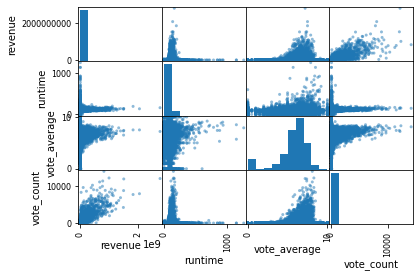

In [ ]:
#scatter matrix
pd.plotting.scatter_matrix(m_df)

#### Calculate c

In [ ]:
vote_counts = m_df[m_df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = m_df[m_df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

#### Calculate m 

In [ ]:
# Calculation of m
m = vote_counts.quantile(0.95)
m

434.0

In [ ]:
# extracting release year from release_date
m_df['year'] = pd.to_datetime(m_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] 
                                                                           if x != np.nan else np.nan)

#### Getting qualified movies (cutoff: 95%)

In [ ]:
col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']
qualified = m_df[(m_df['vote_count'] >= m) 
                 & (m_df['vote_count'].notnull()) 
                 & (m_df['vote_average'].notnull())][col_list]

# converting vote_count and vote_average colums to integer
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)

In [ ]:
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [ ]:
temp = m_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
temp.name = 'genre'
mgen_df = m_df.drop('genres', axis=1).join(temp)

In [ ]:
def make_toplist(genre, percentile=0.85):
    df = mgen_df[mgen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    col_list = ['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genre']
    qualified = df[(df['vote_count'] >= m) 
                   & (df['vote_count'].notnull()) 
                   & (df['vote_average'].notnull())][col_list]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['weighted_rating'] = qualified.apply(lambda x: 
                                                   (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), 
                                                   axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
    return qualified
    

In [ ]:
make_toplist('Romance').head(10)

,title,year,vote_count,vote_average,popularity,genre,weighted_rating
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,Romance,8.565285
351,Forrest Gump,1994,8147,8,48.307194,Romance,7.971357
876,Vertigo,1958,1162,8,18.20822,Romance,7.811667
40251,Your Name.,2016,1030,8,34.461252,Romance,7.789489
883,Some Like It Hot,1959,835,8,11.845107,Romance,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,Romance,7.744878
19901,Paperman,2012,734,8,7.198633,Romance,7.713951
37863,Sing Street,2016,669,8,10.672862,Romance,7.689483
882,The Apartment,1960,498,8,11.994281,Romance,7.599317
38718,The Handmaiden,2016,453,8,16.727405,Romance,7.566166


## Content Based Recommendation model

In [ ]:
small_mdf = pd.read_csv('/content/drive/MyDrive/data/links_small.csv')
small_mdf = small_mdf[small_mdf['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
m_df['id'] = m_df['id'].apply(convert_int)

In [ ]:
m_df[m_df['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,- Written by ÃrnÃ¥s,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': 'æ¥æ¬èª'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,Avalanche Sharks,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [ ]:
m_df = m_df.drop([19730, 29503, 35587])
m_df['id'] = m_df['id'].astype('int')

In [ ]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df.shape

(9099, 25)

In [ ]:
sm_df['tagline'] = sm_df['tagline'].fillna('')
sm_df['description'] = sm_df['overview'] + sm_df['tagline']
sm_df['description'] = sm_df['description'].fillna('')

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(sm_df['description'])
tfidf_matrix.shape

(9099, 268961)

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.00680459, 0.        , ..., 0.        , 0.00289435,
       0.        ])

In [ ]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
indices = pd.Series(sm_df.index, index=sm_df['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [ ]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
8165    Batman: The Dark Knight Returns, Part 1
2696                                        JFK
Name: title, dtype: object

###Metadata Based Recommendation

In [ ]:
credits = pd.read_csv('/content/drive/MyDrive/data/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/data/keywords.csv')

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
m_df['id'] = m_df['id'].astype('int')
m_df.shape

(45463, 25)

In [ ]:
# merging require details with our main dataframe 
m_df = m_df.merge(credits, on='id')
m_df = m_df.merge(keywords, on='id')

In [ ]:
sm_df = m_df[m_df['id'].isin(small_mdf)]
sm_df.shape

(9219, 28)

In [ ]:
sm_df['cast'] = sm_df['cast'].apply(literal_eval)
sm_df['crew'] = sm_df['crew'].apply(literal_eval)
sm_df['keywords'] = sm_df['keywords'].apply(literal_eval)
sm_df['cast_size'] = sm_df['cast'].apply(lambda x: len(x))
sm_df['crew_size'] = sm_df['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
sm_df['director'] = sm_df['crew'].apply(get_director)

In [ ]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
sm_df['cast'] = sm_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
sm_df['cast'] = sm_df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
sm_df['director'] = sm_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
sm_df['director'] = sm_df['director'].apply(lambda x: [x,x])

In [ ]:
s = sm_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
sm_df['keywords'] = sm_df['keywords'].apply(filter_keywords)
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
sm_df['keywords'] = sm_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
sm_df['soup'] = sm_df['keywords'] + sm_df['cast'] + sm_df['director'] + sm_df['genres']
sm_df['soup'] = sm_df['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(sm_df['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
sm_df = sm_df.reset_index()
titles = sm_df['title']
indices = pd.Series(sm_df.index, index=sm_df['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031                 The Dark Knight Rises
6218                         Batman Begins
7659            Batman: Under the Red Hood
6623                          The Prestige
1134                        Batman Returns
8927               Kidnapping Mr. Heineken
5943                              Thursday
1260                        Batman & Robin
2085                             Following
9024    Batman v Superman: Dawn of Justice
Name: title, dtype: object

In [ ]:
get_recommendations('Pulp Fiction').head(10)

1381         Jackie Brown
8905    The Hateful Eight
5200    Kill Bill: Vol. 2
4595                Basic
4764             S.W.A.T.
898        Reservoir Dogs
6939              Cleaner
4903    Kill Bill: Vol. 1
231         Kiss of Death
4306       The 51st State
Name: title, dtype: object

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sm_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
6623,The Prestige,4510,8,2006,7.758148
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
524,Batman,2145,7,1989,6.704647
1031,M,465,8,1931,6.669950
7659,Batman: Under the Red Hood,459,7,2010,6.147016
2085,Following,363,7,1998,6.044272
1134,Batman Returns,1706,6,1992,5.846862
4145,Insomnia,1181,6,2002,5.797081


In [ ]:
improved_recommendations('Pulp Fiction')

,title,vote_count,vote_average,year,wr
898,Reservoir Dogs,3821,8,1992,7.718986
7280,Inglourious Basterds,6598,7,2009,6.891679
4903,Kill Bill: Vol. 1,5091,7,2003,6.862133
8905,The Hateful Eight,4405,7,2015,6.842588
5200,Kill Bill: Vol. 2,4061,7,2004,6.830542
1381,Jackie Brown,1580,7,1997,6.621790
4185,Road to Perdition,1102,7,2002,6.504092
8110,The Raid,1076,7,2011,6.495553
8408,Fast & Furious 6,5282,6,2013,5.942667
8390,Pain & Gain,1595,6,2013,5.838485


## Collaborative Filtering

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

<generator object KFold.split at 0x7fb19cad5a50>

In [ ]:
svd = SVD()
#evaluate(svd, data, measures=['RMSE', 'MAE'])
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9068  0.8914  0.8991  0.8928  0.8979  0.8976  0.0054  
MAE (testset)     0.6978  0.6896  0.6920  0.6867  0.6906  0.6913  0.0037  
Fit time          5.04    5.03    5.08    5.04    7.11    5.46    0.82    
Test time         0.16    0.14    0.33    0.14    0.23    0.20    0.07    


{'test_rmse': array([0.90675998, 0.89143829, 0.89912178, 0.89279284, 0.89786352]),
 'test_mae': array([0.69776146, 0.68955414, 0.69200569, 0.68668447, 0.69055135]),
 'fit_time': (5.042079448699951,
  5.034100532531738,
  5.083547592163086,
  5.0355165004730225,
  7.105119943618774),
 'test_time': (0.1620490550994873,
  0.14026165008544922,
  0.325122594833374,
  0.14480113983154297,
  0.2317502498626709)}

In [ ]:
trainset = data.build_full_trainset()
#svd.train(trainset)
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7487192958824487, details={'was_impossible': False})

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('/content/drive/MyDrive/data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(sm_df[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')
id_map

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
...,...,...
The Last Brickmaker in America,161944,159550.0
Rustom,162542,392572.0
Mohenjo Daro,162672,402672.0


In [ ]:
indices_map = id_map.set_index('id')

**HYBRID RECOMMENDATION MODEL**

In [ ]:
def hybrid(userId, title):
    #Data formatting
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    #CBF
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    #CF
    movies = sm_df.iloc[movie_indices][['title', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'Avatar')

,title,id,est
522,Terminator 2: Judgment Day,280,3.209058
1011,The Terminator,218,3.096875
8658,X-Men: Days of Future Past,127585,3.004945
974,Aliens,679,2.963379
1621,Darby O'Gill and the Little People,18887,2.958539
2834,Predator,106,2.930840
8401,Star Trek Into Darkness,54138,2.897134
2014,Fantastic Planet,16306,2.878538
7705,Alice in Wonderland,25694,2.801242
922,The Abyss,2756,2.755579


In [ ]:
hybrid(500, 'Avatar')

,title,id,est
1011,The Terminator,218,3.648000
1621,Darby O'Gill and the Little People,18887,3.249117
922,The Abyss,2756,3.228429
2014,Fantastic Planet,16306,3.162523
8658,X-Men: Days of Future Past,127585,3.106462
1668,Return from Witch Mountain,14822,3.074376
7705,Alice in Wonderland,25694,3.063120
4017,Hawk the Slayer,25628,3.061594
2834,Predator,106,3.003136
8419,Man of Steel,49521,2.934354
